# Text Processing - Yelp 2021 - Part 1

This notebook covers:
* Wordclouds
* Basic Text Characteristics (word count, character count, average word length, etc)
* Text Reading Level (Textstat)
* Text Sentiment (Textblob)
* Linguistic Characterics (parts-of-speech, named entities, syntactic relationships - Spacy)

## Imports and Global Settings

In [1]:
# Common Libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Main NLP libraries
import nltk
import gensim
# Wordclouds
from wordcloud import WordCloud, STOPWORDS
# Reading Level and Basic Stats
import textstat
from nltk.corpus import stopwords as nltk_stopwords
# Sentiment Analysis
from textblob import TextBlob
# Parts of Speech, Named Entities, Syntactic Dependencies
import spacy
# Classification
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import make_scorer, recall_score, precision_score
from sklearn.naive_bayes import MultinomialNB
#
from nltk.stem import WordNetLemmatizer
from sklearn.feature_selection import chi2
# Word2Vec
from gensim.models import Word2Vec
import gensim.downloader as api


pd.set_option('display.float_format', lambda x: '%.5f' % x)

/home/jeff/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Import Data

In [2]:
file_location = "../data/full_data/analytics_ready/"
filename = "text_data_train.json"

In [3]:
# 5523992 training records available
num_records_to_load = 1000

In [4]:
df = pd.read_json(file_location + filename, nrows=num_records_to_load, orient="records", lines=True)

## Dataframe Pre-Processing

In [5]:
df.head(5)

,review_id,review_stars,review_text,target_ufc_bool,target_ufc_count
0,---zlFD4Kgfatr0SbDh_zg,4,Been looking for a halfway decent Chinese/Amer...,False,0
1,--BcxYRlOpG0v7nVQWseYA,4,I visited Kyma last week for the first time an...,False,0
2,--KO46TSxWzv32x00s5w9Q,5,It might be the most expensive gelato I've eve...,False,0
3,--XNrIWxRUafMsGqzB5o0g,5,"Love this place! They have great antiques, be...",True,1
4,--aGgQu9HVva6F9fB2-0ew,4,Great salad and cold sandwich.. The soup is am...,False,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         1000 non-null   object
 1   review_stars      1000 non-null   int64 
 2   review_text       1000 non-null   object
 3   target_ufc_bool   1000 non-null   object
 4   target_ufc_count  1000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 39.2+ KB


In [7]:
df.target_ufc_bool.value_counts()

True     522
False    478
Name: target_ufc_bool, dtype: int64

## Splitting Text

In [8]:
corpus = df.review_text
text_target = df[['target_ufc_bool', 'review_text']]
Q_corpus = df[df["target_ufc_bool"] == "True"]["review_text"]
NQ_corpus = df[df["target_ufc_bool"] == "False"]["review_text"]
print(f'Corpus Size: Total:{corpus.size}, Quality:{Q_corpus.size}, Not Quality:{NQ_corpus.size}')

Corpus Size: Total:1000, Quality:522, Not Quality:478


## WordClouds

### Wordcloud Stopwords

In [9]:
stopwords = set(STOPWORDS)
stopwords.update([])

#### Join Corpus Into One String

In [10]:
Q_text = " ".join(review for review in Q_corpus)
NQ_text = " ".join(review for review in NQ_corpus)

### Make Wordclouds

In [11]:
Q_wordcloud = WordCloud(stopwords=stopwords, background_color="cornflowerblue", colormap="Set1",
                      collocations=False, color_func=lambda *args, **kwargs: "black",
                      width=1000, height=1000).generate(Q_text)

In [12]:
NQ_wordcloud = WordCloud(stopwords=stopwords, background_color="lightcoral", colormap="Set1",
                      collocations=False, color_func=lambda *args, **kwargs: "black",
                      width=1000, height=1000).generate(NQ_text)

### Save and Show Wordclouds

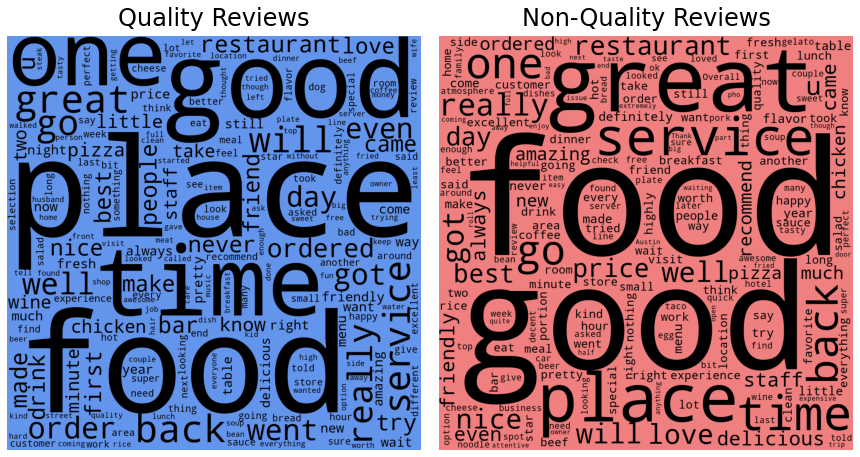

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


ax1.imshow(Q_wordcloud)
ax1.axis("off")
ax1.set_title("Quality Reviews", fontsize=24, pad=10)


ax2.imshow(NQ_wordcloud)
ax2.axis("off")
ax2.set_title("Non-Quality Reviews", fontsize=24, pad=10)

fig.tight_layout(pad=0)

# plt.savefig('../images/review_wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()

## Basic Text Characteristics

In [14]:
text = df.copy()

### Feature Creation

In [15]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

In [16]:
text['word_count'] = text['review_text'].apply(lambda x: len(str(x).split(" ")))
text['character_count'] = text['review_text'].str.len()
text['avg_word_length'] = text['review_text'].apply(lambda x: avg_word(x))
text['num_count'] = text['review_text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
text['uppercase_count'] = text['review_text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
text['#_@_count'] = text['review_text'].apply(lambda x: len([x for x in x.split() if x.startswith('#') or x.startswith('@')]))

In [17]:
text["sentence_count"] = text["review_text"].apply(textstat.sentence_count)
text["lexicon_count"] = text["review_text"].apply(textstat.lexicon_count)
text["syllable_count"] = text["review_text"].apply(textstat.syllable_count)

In [18]:
text.info()
text.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         1000 non-null   object 
 1   review_stars      1000 non-null   int64  
 2   review_text       1000 non-null   object 
 3   target_ufc_bool   1000 non-null   object 
 4   target_ufc_count  1000 non-null   int64  
 5   word_count        1000 non-null   int64  
 6   character_count   1000 non-null   int64  
 7   avg_word_length   1000 non-null   float64
 8   num_count         1000 non-null   int64  
 9   uppercase_count   1000 non-null   int64  
 10  #_@_count         1000 non-null   int64  
 11  sentence_count    1000 non-null   int64  
 12  lexicon_count     1000 non-null   int64  
 13  syllable_count    1000 non-null   int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 109.5+ KB


,review_id,review_stars,review_text,target_ufc_bool,target_ufc_count,word_count,character_count,avg_word_length,num_count,uppercase_count,#_@_count,sentence_count,lexicon_count,syllable_count
0,---zlFD4Kgfatr0SbDh_zg,4,Been looking for a halfway decent Chinese/Amer...,False,0,37,198,4.37838,0,0,0,3,37,47
1,--BcxYRlOpG0v7nVQWseYA,4,I visited Kyma last week for the first time an...,False,0,98,553,4.65306,3,2,0,6,98,138
2,--KO46TSxWzv32x00s5w9Q,5,It might be the most expensive gelato I've eve...,False,0,44,240,4.47727,0,0,0,4,44,62
3,--XNrIWxRUafMsGqzB5o0g,5,"Love this place! They have great antiques, be...",True,1,117,593,4.29730,2,1,0,1,110,143
4,--aGgQu9HVva6F9fB2-0ew,4,Great salad and cold sandwich.. The soup is am...,False,0,19,101,4.36842,0,0,0,3,19,24


## Reading Level

In [19]:
text["grade_level"] = text["review_text"].apply(textstat.flesch_kincaid_grade)

In [20]:
text.info()
text.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         1000 non-null   object 
 1   review_stars      1000 non-null   int64  
 2   review_text       1000 non-null   object 
 3   target_ufc_bool   1000 non-null   object 
 4   target_ufc_count  1000 non-null   int64  
 5   word_count        1000 non-null   int64  
 6   character_count   1000 non-null   int64  
 7   avg_word_length   1000 non-null   float64
 8   num_count         1000 non-null   int64  
 9   uppercase_count   1000 non-null   int64  
 10  #_@_count         1000 non-null   int64  
 11  sentence_count    1000 non-null   int64  
 12  lexicon_count     1000 non-null   int64  
 13  syllable_count    1000 non-null   int64  
 14  grade_level       1000 non-null   float64
dtypes: float64(2), int64(10), object(3)
memory usage: 117.3+ KB


,review_id,review_stars,review_text,target_ufc_bool,target_ufc_count,word_count,character_count,avg_word_length,num_count,uppercase_count,#_@_count,sentence_count,lexicon_count,syllable_count,grade_level
0,---zlFD4Kgfatr0SbDh_zg,4,Been looking for a halfway decent Chinese/Amer...,False,0,37,198,4.37838,0,0,0,3,37,47,4.50000
1,--BcxYRlOpG0v7nVQWseYA,4,I visited Kyma last week for the first time an...,False,0,98,553,4.65306,3,2,0,6,98,138,7.30000
2,--KO46TSxWzv32x00s5w9Q,5,It might be the most expensive gelato I've eve...,False,0,44,240,4.47727,0,0,0,4,44,62,5.20000
3,--XNrIWxRUafMsGqzB5o0g,5,"Love this place! They have great antiques, be...",True,1,117,593,4.29730,2,1,0,1,110,143,42.70000
4,--aGgQu9HVva6F9fB2-0ew,4,Great salad and cold sandwich.. The soup is am...,False,0,19,101,4.36842,0,0,0,3,19,24,2.20000


## Sentiment Analysis

In [21]:
text["polarity"] = text["review_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
text["subjectivity"] = text["review_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [22]:
text.info()
text.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         1000 non-null   object 
 1   review_stars      1000 non-null   int64  
 2   review_text       1000 non-null   object 
 3   target_ufc_bool   1000 non-null   object 
 4   target_ufc_count  1000 non-null   int64  
 5   word_count        1000 non-null   int64  
 6   character_count   1000 non-null   int64  
 7   avg_word_length   1000 non-null   float64
 8   num_count         1000 non-null   int64  
 9   uppercase_count   1000 non-null   int64  
 10  #_@_count         1000 non-null   int64  
 11  sentence_count    1000 non-null   int64  
 12  lexicon_count     1000 non-null   int64  
 13  syllable_count    1000 non-null   int64  
 14  grade_level       1000 non-null   float64
 15  polarity          1000 non-null   float64
 16  subjectivity      1000 non-null   float64
d

,review_id,review_stars,review_text,target_ufc_bool,target_ufc_count,word_count,character_count,avg_word_length,num_count,uppercase_count,#_@_count,sentence_count,lexicon_count,syllable_count,grade_level,polarity,subjectivity
0,---zlFD4Kgfatr0SbDh_zg,4,Been looking for a halfway decent Chinese/Amer...,False,0,37,198,4.37838,0,0,0,3,37,47,4.50000,0.45333,0.54333
1,--BcxYRlOpG0v7nVQWseYA,4,I visited Kyma last week for the first time an...,False,0,98,553,4.65306,3,2,0,6,98,138,7.30000,0.16399,0.51190
2,--KO46TSxWzv32x00s5w9Q,5,It might be the most expensive gelato I've eve...,False,0,44,240,4.47727,0,0,0,4,44,62,5.20000,0.47396,0.55833
3,--XNrIWxRUafMsGqzB5o0g,5,"Love this place! They have great antiques, be...",True,1,117,593,4.29730,2,1,0,1,110,143,42.70000,0.23874,0.61131
4,--aGgQu9HVva6F9fB2-0ew,4,Great salad and cold sandwich.. The soup is am...,False,0,19,101,4.36842,0,0,0,3,19,24,2.20000,0.40000,0.85000


## Linguistic Components with Spacy

In [23]:
pos_list = ["ADJ", "ADP", "ADV", "AUX", "CONJ", "DET", "INTJ", "NOUN", "NUM",
            "PART", "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X",]
dep_list = ["ROOT", "acl", "acomp", "advcl", "advmod", "agent", "amod",
            "appos", "attr", "aux", "auxpass", "case", "cc", "ccomp",
            "compound", "conj", "csubj", "csubjpass", "dative", "dep", "det",
            "dobj", "expl", "intj", "mark", "meta", "neg", "nmod", "npadvmod",
            "nsubj", "nsubjpass", "nummod", "oprd", "parataxis", "pcomp",
            "pobj", "poss", "preconj", "predet", "prep", "prt", "punct",
            "quantmod", "relcl","xcomp"]
ent_list = ["CARDINAL", "DATE", "EVENT", "FAC", "GPE", "LANGUAGE", "LAW",
            "LOC", "MONEY", "NORP", "ORDINAL", "ORG", "PERCENT", "PERSON",
            "PRODUCT", "QUANTITY", "TIME", "WORK_OF_ART"]

In [24]:
nlp = spacy.load("en_core_web_sm")

In [25]:
def create_spacy_features(df, text_feature_name):
    """
    Adds various features using Spacy's library and NLP models.

    Key Terms:
        pos_dict: Part of Speech
                  https://universaldependencies.org/u/pos/

        dep_list: Universal Dependency Relations
                  https://universaldependencies.org/u/dep/

        ent_list: Named Entity
                  https://spacy.io/api/annotation#named-entities
    """
    
    df["spacy_doc"] = df[text_feature_name].apply(lambda x: nlp(x))
    df["token_count"] = df["spacy_doc"].apply(lambda x: len(x))
    df["stopword_perc"] = df["spacy_doc"].apply(lambda x: round(len([token for token in x if token.is_stop]) / len(x), 5))
    df["stopword_count"] = df["spacy_doc"].apply(lambda x: len([token for token in x if token.is_stop]))
    df["ent_perc"] = df["spacy_doc"].apply(lambda x: round(len(x.ents) / len(x), 5))
    df["ent_count"] = df["spacy_doc"].apply(lambda x: len(x.ents))
    
    for pos in pos_list:
        df[f"pos_{pos.lower()}_perc"] = df["spacy_doc"].apply(
            lambda x: round(len([token for token in x if token.pos_ == pos]) / len(x), 5))
        df[f"pos_{pos.lower()}_count"] = df["spacy_doc"].apply(
            lambda x: len([token for token in x if token.pos_ == pos]))

    for dep in dep_list:
        df[f"dep_{dep.lower()}_perc"] = df["spacy_doc"].apply(
            lambda x: round(len([token for token in x if token.dep_ == dep]) / len(x), 5))
        df[f"dep_{dep.lower()}_count"] = df["spacy_doc"].apply(
            lambda x: len([token for token in x if token.dep_ == dep]))
    
    for ent in ent_list:
        df[f"ent_{ent.lower()}_perc"] = df["spacy_doc"].apply(
            lambda x: round(len([y for y in x.ents if y.label_ == ent]) / len(x), 5))
        df[f"ent_{ent.lower()}_count"] = df["spacy_doc"].apply(
            lambda x: len([y for y in x.ents if y.label_ == ent]))

    df.drop("spacy_doc", axis=1, inplace=True)
    
    return df

In [26]:
text = create_spacy_features(text, 'review_text')

In [27]:
text.info()
text.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 182 entries, review_id to ent_work_of_art_count
dtypes: float64(86), int64(93), object(3)
memory usage: 1.4+ MB


,review_id,review_stars,review_text,target_ufc_bool,target_ufc_count,word_count,character_count,avg_word_length,num_count,uppercase_count,...,ent_person_perc,ent_person_count,ent_product_perc,ent_product_count,ent_quantity_perc,ent_quantity_count,ent_time_perc,ent_time_count,ent_work_of_art_perc,ent_work_of_art_count
0,---zlFD4Kgfatr0SbDh_zg,4,Been looking for a halfway decent Chinese/Amer...,False,0,37,198,4.37838,0,0,...,0.04651,2,0.00000,0,0.00000,0,0.00000,0,0.00000,0
1,--BcxYRlOpG0v7nVQWseYA,4,I visited Kyma last week for the first time an...,False,0,98,553,4.65306,3,2,...,0.00909,1,0.00000,0,0.00000,0,0.00000,0,0.00000,0
2,--KO46TSxWzv32x00s5w9Q,5,It might be the most expensive gelato I've eve...,False,0,44,240,4.47727,0,0,...,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0
3,--XNrIWxRUafMsGqzB5o0g,5,"Love this place! They have great antiques, be...",True,1,117,593,4.29730,2,1,...,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0
4,--aGgQu9HVva6F9fB2-0ew,4,Great salad and cold sandwich.. The soup is am...,False,0,19,101,4.36842,0,0,...,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0
